# CH8 Dimensionality Reduction

Principal Components

In [1]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.datasets import fetch_openml

In [2]:
mnist = fetch_openml('mnist_784', as_frame=False)

c:\Users\sayed\anaconda3\lib\site-packages\sklearn\datasets\_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [3]:
X_train, y_train = mnist.data[:60_000], mnist.target[:60_000]
X_test, y_test = mnist.data[60_000:], mnist.target[60_000:]
pca = PCA()
pca.fit(X_train)

PCA()

In [4]:
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= .95)+1
d

154

In [5]:
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train)

In [6]:
X_reduced.shape

(60000, 154)

In [7]:
pca.n_components_

154

In [8]:
pca.explained_variance_ratio_.sum()

0.9501960192613026

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import RandomizedSearchCV

clf = make_pipeline(PCA(random_state=42),
                    RandomForestClassifier(random_state=42))
param_dist = {
    "pca__n_components": np.arange(10, 80),
    'randomforestclassifier__n_estimators': np.arange(50, 500)

}
rnd_search = RandomizedSearchCV(
    clf, param_dist, n_iter=10, cv=3, random_state=42)
rnd_search.fit(X_train[:1000], y_train[:1000])

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('pca', PCA(random_state=42)),
                                             ('randomforestclassifier',
                                              RandomForestClassifier(random_state=42))]),
                   param_distributions={'pca__n_components': array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
       27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43,
       44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60,
       6...
       414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426,
       427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439,
       440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452,
       453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465,
       466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478,
       479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491,
       492, 493, 494, 495, 496, 497, 498, 499])},
                   random_state=42)

In [10]:
rnd_search.best_params_

{'randomforestclassifier__n_estimators': 465, 'pca__n_components': 23}

In [11]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV

clf = make_pipeline(PCA(random_state=42), SGDClassifier())
param_grid = {"pca__n_components": np.arange(10, 80)}
grid_search = GridSearchCV(clf, param_grid, cv=3)
grid_search.fit(X_train[:1000], y_train[:1000])

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('pca', PCA(random_state=42)),
                                       ('sgdclassifier', SGDClassifier())]),
             param_grid={'pca__n_components': array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
       27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43,
       44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60,
       61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77,
       78, 79])})

In [12]:
grid_search.best_params_

{'pca__n_components': 75}

PCA for compression

In [13]:
pca = PCA(.95)
X_reduced = pca.fit_transform(X_train, y_train)

In [14]:
X_recovered = pca.inverse_transform(X_reduced)

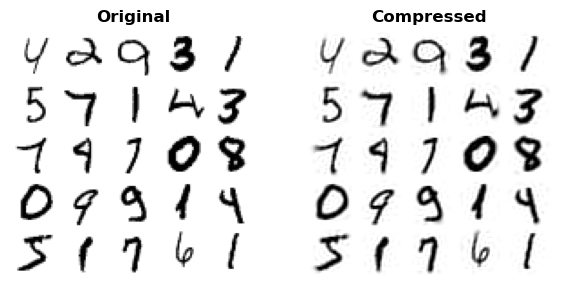

In [15]:
import matplotlib.pyplot as plt
plt.figure(figsize=(7, 4))
for idx, X in enumerate((X_train[::2100], X_recovered[::2100])):
    plt.subplot(1, 2, idx + 1)
    plt.title(["Original", "Compressed"][idx])
    for row in range(5):
        for col in range(5):
            plt.imshow(X[row * 5 + col].reshape(28, 28), cmap="binary",
                       vmin=0, vmax=255, extent=(row, row + 1, col, col + 1))
            plt.axis([0, 5, 0, 5])
            plt.axis("off")

Randomized PCA

In [16]:
rnd_pca = PCA(n_components=154, svd_solver="randomized", random_state=42)
X_reduced = rnd_pca.fit_transform(X_train)

Incremental PCA

In [17]:
from sklearn.decomposition import IncrementalPCA

n_batches = 100
inc_pca = IncrementalPCA(n_components=154)
for X_batch in np.array_split(X_train, n_batches):
    inc_pca.partial_fit(X_batch)

X_reduced = inc_pca.transform(X_train)

Using NumPy's memmap class – a memory-map to an array stored in a binary file on disk.

In [18]:
# filename = "my_mnist.mmap"
# X_mmap = np.memmap(filename, dtype='float32',
#                    mode='write', shape=X_train.shape)
# X_mmap[:] = X_train  # could be a loop instead, saving the data chunk by chunk
# X_mmap.flush()

In [19]:
# X_mmap = np.memmap(filename, dtype="float32", mode="readonly").reshape(-1, 784)
# batch_size = X_mmap.shape[0] // n_batches
# inc_pca = IncrementalPCA(n_components=154, batch_size=batch_size)
# inc_pca.fit(X_mmap)

#### Random Projection

In [20]:
from sklearn.random_projection import johnson_lindenstrauss_min_dim
m, eps = 5000, 0.1
d = johnson_lindenstrauss_min_dim(m, eps=eps)
d

7300

In [21]:
n = 20_000
np.random.seed(42)
P = np.random.randn(d, n)/np.sqrt(d)
X = np.random.randn(m, n)
X_reduced = X @ P.T

In [22]:
X_reduced.shape

(5000, 7300)

In [23]:
X_reduced[0]

array([ 0.65601016, -1.52157349, -2.13016582, ..., -3.30298058,
        1.86509223, -0.62205374])

In [24]:
from sklearn.random_projection import GaussianRandomProjection

gaussian_rnd_proj = GaussianRandomProjection(eps=eps, random_state=42)
X_reduced = gaussian_rnd_proj.fit_transform(X)

In [25]:
X_reduced.shape

(5000, 7300)

In [26]:
X_reduced[0]

array([ 0.65601016, -1.52157349, -2.13016582, ..., -3.30298058,
        1.86509223, -0.62205374])

same results as above

In [27]:
gaussian_rnd_proj.components_.shape  # P with shape [d, n]

(7300, 20000)

In [28]:
# this cell takes alot of time ~5m
# components_pinv = np.linalg.pinv(gaussian_rnd_proj.components_)
# X_recovered = X_reduced @ components_pinv.T

Sparse Random Projection >> less memory - 50% faster than gaussian

In [29]:
from sklearn.random_projection import SparseRandomProjection

sp_rnd_proj = SparseRandomProjection(eps=eps, random_state=42)
X_reduced_sparse = sp_rnd_proj.fit_transform(X)

#### LLE

In [30]:
from sklearn.datasets import make_swiss_roll
from sklearn.manifold import LocallyLinearEmbedding

X_swiss, t = make_swiss_roll(n_samples=1000, noise=.2, random_state=42)
lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10, random_state=42)
X_unrolled = lle.fit_transform(X_swiss)

In [31]:
X_swiss

array([[-3.29677117,  4.26198454,  7.69787682],
       [ 5.95972743, 11.45784273, 12.72625276],
       [ 6.66051523, 18.15820401, -9.84713337],
       ...,
       [ 6.18364276,  1.44095323, -1.71242696],
       [ 5.86076169,  1.09185823, 12.47091112],
       [-8.16213703,  5.61235668,  4.51171684]])

In [32]:
X_unrolled

array([[ 0.010835  , -0.04071135],
       [-0.05152021,  0.04027855],
       [-0.02360868,  0.01473808],
       ...,
       [ 0.03497449, -0.01793337],
       [-0.05313049,  0.02821384],
       [ 0.00434432, -0.04424256]])

In [33]:
t[:10]

array([ 8.24234644, 13.67266022, 11.61126935, 10.35461227,  6.18283002,
        6.1826027 ,  5.25981413, 12.87590683, 10.37776449, 11.38581581])

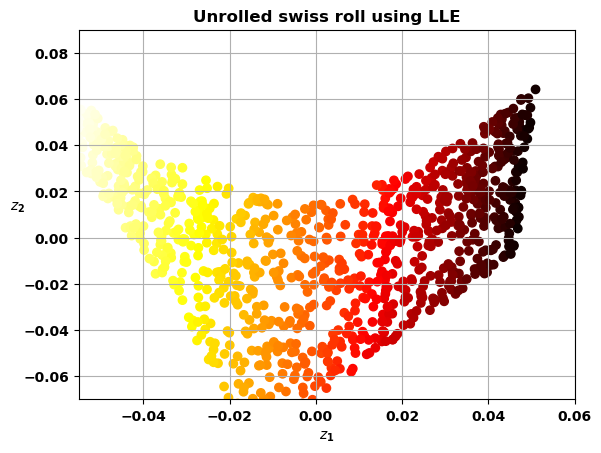

In [35]:
plt.scatter(X_unrolled[:, 0], X_unrolled[:, 1], c=t, cmap='hot')
plt.xlabel("$z_1$")
plt.ylabel("$z_2$", rotation=0)
plt.axis([-0.055, 0.060, -0.070, 0.090])
plt.grid(True)

plt.title("Unrolled swiss roll using LLE")
plt.show()

In [36]:
from sklearn.manifold import MDS

mds = MDS(n_components=2, normalized_stress=False, random_state=42)
X_reduced_mds = mds.fit_transform(X_swiss)

In [37]:
from sklearn.manifold import Isomap

isomap = Isomap(n_components=2)
X_reduced_isomap = isomap.fit_transform(X_swiss)

In [38]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, init="random", learning_rate="auto",
            random_state=42)
X_reduced_tsne = tsne.fit_transform(X_swiss)

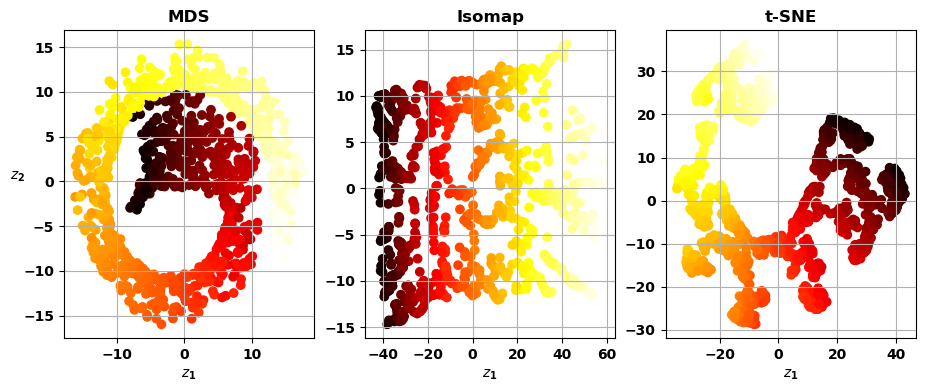

In [41]:
titles = ["MDS", "Isomap", "t-SNE"]

plt.figure(figsize=(11, 4))

for subplot, title, X_reduced in zip((131, 132, 133), titles,
                                     (X_reduced_mds, X_reduced_isomap, X_reduced_tsne)):
    plt.subplot(subplot)
    plt.title(title)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap='hot')
    plt.xlabel("$z_1$")
    if subplot == 131:
        plt.ylabel("$z_2$", rotation=0)
    plt.grid(True)

plt.show()